### Variable Names and Descriptions:
  * <b>data</b> = geopandas dataframe of ARC shape file
  * <b>stream_rivers</b> = data subframe where feature type is Stream/River
  
  
  * <b>proctor_creeks</b> = stream_rivers subframe where name contains proctor
    * <b>proctor_creek</b> = proctor_creeks subframe where countyFIPS is fulton (121)
  * <b>chatahoochee_rivers</b> = stream_rivers subframe where name contains chatahoochee
    * <b>chatahoochee_river</b> = chatahoochee_rivers subframe where countyFIPS is fulton (121)
   
   
  * <b>pc_bbox</b> = array (w, s, e, n) of values bounding line shape stored in proctor_creek 
  * <b>cr_bbox</b> = array of values bounding line shape stored in chattahoochee_river 
    * <b>cr_upstream</b> array of values bounding nw of pc_bbox and ne of cr_bbox, <i>defines portion of chattahoochee_river upstream from proctor_creek</i>
    
    
  * <b>pc_stations</b> = geopandas dataframe of geojson pulled from uswaterdata using bbox (in pc_bbox, near proctor_creek)
  * <b>cr_stations</b> = geopandas dataframe of geojson pulled from uswaterdata using bbox (in cr_upstream, near chattahoochee_river)
  * <b>all_stations</b> = <i>re-indexed</i> geopandas dataframe combination of cr_stations and pc_stations with activityCount greater than 200
  
  
  * <b>coliformSimple</b> = all coliform results for all stations scrubbed from uswaterquality. Organized linearly by stations moving south and then by date getting more recent

In [1]:
#import libraries
#john was here
import time
import json
import requests
import numpy as np
import pandas as pd
import geopandas as gpd
from io import StringIO

%matplotlib inline
import matplotlib.pyplot as plt


#import ARC river and streams data 
data = gpd.read_file('data/Rivers_Streams_Atlanta_Region.shp')
streams_rivers = data[data['FEATURE_TY'] == 'Stream/River']

In [2]:
#determine syntax of identifiers

for i, stream in streams_rivers.iterrows():
    name = stream['NAME']
    if name is not None and 'Chattahoochee' in name:
        print(name)
        
for i, stream in streams_rivers.iterrows():
    name = stream['NAME']
    if name is not None and 'Proctor' in name:
        print(name)

Chattahoochee River
Chattahoochee River
Chattahoochee River
Chattahoochee River
Chattahoochee River
Chattahoochee River
Chattahoochee River
Chattahoochee River
Chattahoochee River
Chattahoochee River
Chattahoochee River
Chattahoochee River
Chattahoochee River
Chattahoochee River
Chattahoochee River
Proctor Creek
Proctor Creek


In [3]:
#isolate data for proctor creek and chattahoochee river in fulton county (FIP 121)

proctor_creeks = streams_rivers[streams_rivers['NAME'] == 'Proctor Creek']
proctor_creek = proctor_creeks[proctor_creeks['COUNTY_FIP'] == '121']

chattahoochee_rivers = streams_rivers[streams_rivers['NAME'] == 'Chattahoochee River']
chattahoochee_river = chattahoochee_rivers[chattahoochee_rivers['COUNTY_FIP'] == '121']

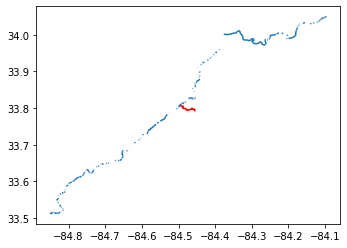

In [4]:
#plot

ax = chattahoochee_river.plot()
proctor_creek.plot(ax=ax, color='r')

In [5]:
#determine bounding boxes for proctor creek and chattahoochee river

def boundingBox(line):
    #takes in a line shape file and returns the bounding box as an array [west, south, east, north]
    line_bounds = line.bounds
    line_maxx = line_bounds['maxx'].tolist()
    line_maxy = line_bounds['maxy'].tolist()
    line_minx = line_bounds['minx'].tolist()
    line_miny = line_bounds['miny'].tolist()
    return [min(line_minx), min(line_miny), max(line_maxx), max(line_maxy)]

pc = proctor_creek['geometry']
cr = chattahoochee_river['geometry']

pc_bbox = boundingBox(pc)
cr_bbox = boundingBox(cr)

print(pc_bbox)
print(cr_bbox)

[-84.49604634545041, 33.792362810882956, -84.45397930315823, 33.80783522461392]
[-84.8503020000398, 33.51122644162358, -84.09771636577764, 34.05055910826992]


In [6]:
#obtain us water quality station data for proctor creek and chattahoochee river

def getStations(line, tol=0.005, boundsArr=[]):
    
    #returns all stations bordering (tolerance) a line shape within a certain bounding box [w, s, e, n]
    if len(boundsArr)==0:
        boundsArr = boundingBox(line)
    
    urlTemplate = 'https://www.waterqualitydata.us/data/Station/search?bBox={west},{south},{east},{north}&mimeType=geojson'
    url = urlTemplate.format(west=boundsArr[0], south=boundsArr[1], east=boundsArr[2], north=boundsArr[3])
    response = requests.get(url)
    with open('data/temp.geojson', 'w') as f:
        f.write(response.text)
    
    stations = gpd.read_file('data/temp.geojson')
    
    idxs = []
    for i, stream in line.iterrows():
        for j, station in stations.iterrows():
            if stream['geometry'].distance(station['geometry']) < tol:
                idxs.append(j)
            
    close_stations = stations.loc[idxs]
    return close_stations

cr_upstream = [pc_bbox[0], pc_bbox[3], cr_bbox[2], cr_bbox[3]] #clip chattahoochee to areas upstream from proctor creek

pc_stations = getStations(proctor_creek)
cr_stations = getStations(chattahoochee_river, boundsArr=cr_upstream)

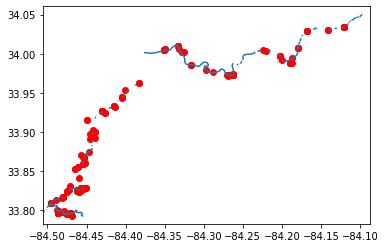

In [7]:
#plot stations

fig, ax = plt.subplots()
ax.set_xlim(pc_bbox[0]-.01, cr_bbox[2]+.01)
ax.set_ylim(pc_bbox[1]-.01, cr_bbox[3]+.01)

proctor_creek.plot(ax=ax)
chattahoochee_river.plot(ax=ax)
pc_stations.plot(ax=ax, color='r')
cr_stations.plot(ax=ax, color='r')

In [8]:
#create new geojson with these stations that have more than 200 activities

def largeStations(stations, count):
    #returns items in stations with activityCount greater than count
    stations['activityCount'] = pd.to_numeric(stations['activityCount'])
    return stations[stations['activityCount']>count]

all_stations = gpd.GeoDataFrame( pd.concat( [largeStations(cr_stations, 200), largeStations(pc_stations, 200)], ignore_index=True) )

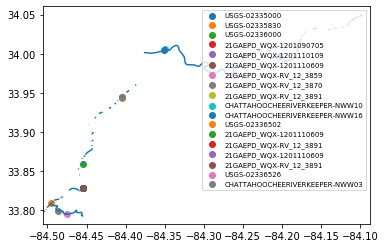

In [9]:
#plot stations

fig, ax = plt.subplots()
ax.set_xlim(pc_bbox[0]-.01, cr_bbox[2]+.01)
ax.set_ylim(pc_bbox[1]-.01, cr_bbox[3]+.01)

proctor_creek.plot(ax=ax)
chattahoochee_river.plot(ax=ax)
for i in all_stations['MonitoringLocationIdentifier'].tolist():
    all_stations[all_stations['MonitoringLocationIdentifier']==i].plot(ax=ax,label=i)
ax.legend(fontsize='x-small')

In [10]:
#retrieve coliform data

print(all_stations['siteUrl'][3])
url = "https://www.waterqualitydata.us/data/Station/search?siteid=" + all_stations['MonitoringLocationIdentifier'][3]
print(url)

response = requests.get(all_stations['siteUrl'][3])
response2 = requests.get(url)

type(response2)


https://www.waterqualitydata.us/data/provider/STORET/21GAEPD_WQX/21GAEPD_WQX-1201090705/
https://www.waterqualitydata.us/data/Station/search?siteid=21GAEPD_WQX-1201090705


requests.models.Response

In [11]:
cc = pd.DataFrame()
ph = pd.DataFrame()
do = pd.DataFrame()
sc = pd.DataFrame()
tu = pd.DataFrame()

siteIDs = all_stations['MonitoringLocationIdentifier'].tolist()

for siteID in siteIDs:
    
    print(siteID, end=', ')
    
    url = 'https://www.waterqualitydata.us/data/Result/search?siteid=' + siteID + '&CharacteristicName=Total%20Coliform&CharacteristicName=Fecal%20Coliform&CharacteristicName=pH&CharacteristicName=Dissolved%20oxygen%20(DO)&CharacteristicName=Specific%20conductance&CharacteristicName=Turbidity'
    response = requests.get(url)
    
    csv = StringIO(response.text)
    data = pd.read_csv(csv)
    
    if (len(data[data['CharacteristicName']=='Fecal Coliform']) != 0):
        cc = pd.concat((cc,data[data['CharacteristicName']=='Fecal Coliform']), axis=0)
    
    if (len(data[data['CharacteristicName']=='Total Coliform']) != 0):
        cc = pd.concat((cc,data[data['CharacteristicName']=='Total Coliform']), axis=0)
    
    if (len(data[data['CharacteristicName']=='pH']) != 0):
        ph = pd.concat((ph,data[data['CharacteristicName']=='pH']), axis=0)
    
    if (len(data[data['CharacteristicName']=='Dissolved oxygen (DO)']) != 0):
        do = pd.concat((do,data[data['CharacteristicName']=='Dissolved oxygen (DO)']), axis=0)
    
    if (len(data[data['CharacteristicName']=='Specific conductance']) != 0):
        sc = pd.concat((sc,data[data['CharacteristicName']=='Specific conductance']), axis=0)
    
    if (len(data[data['CharacteristicName']=='Turbidity']) != 0):
        tu = pd.concat((tu,data[data['CharacteristicName']=='Turbidity']), axis=0)

data_all = pd.concat((cc,ph,do,sc,tu), axis=0)
data_all = data_all[~data_all['ResultMeasureValue'].isna()]

USGS-02335000, USGS-02335830, USGS-02336000, 21GAEPD_WQX-1201090705, 21GAEPD_WQX-1201110109, 21GAEPD_WQX-1201110609, 21GAEPD_WQX-RV_12_3859, 21GAEPD_WQX-RV_12_3870, 21GAEPD_WQX-RV_12_3891, CHATTAHOOCHEERIVERKEEPER-NWW10, CHATTAHOOCHEERIVERKEEPER-NWW16, USGS-02336502, 21GAEPD_WQX-1201110609, 21GAEPD_WQX-RV_12_3891, 21GAEPD_WQX-1201110609, 21GAEPD_WQX-RV_12_3891, USGS-02336526, CHATTAHOOCHEERIVERKEEPER-NWW03, 

In [12]:
dates = data_all['ActivityStartDate'].values.tolist()
times = data_all['ActivityStartTime/Time'].values.tolist()

datetimes = []
for di,ti in zip(dates, times):
    if type(ti) is str:
        datetimes.append(di+' '+ti)
    else:
        datetimes.append(np.nan)

datetimes = pd.to_datetime(datetimes)
data_all_datetime = data_all
data_all_datetime['DateTimes'] = datetimes
data_all_datetime.head(5)

,OrganizationIdentifier,OrganizationFormalName,ActivityIdentifier,ActivityTypeCode,ActivityMediaName,ActivityMediaSubdivisionName,ActivityStartDate,ActivityStartTime/Time,ActivityStartTime/TimeZoneCode,ActivityEndDate,...,MethodDescriptionText,LaboratoryName,AnalysisStartDate,ResultLaboratoryCommentText,DetectionQuantitationLimitTypeName,DetectionQuantitationLimitMeasure/MeasureValue,DetectionQuantitationLimitMeasure/MeasureUnitCode,PreparationStartDate,ProviderName,DateTimes
28,USGS-GA,USGS Georgia Water Science Center,nwisga.01.97601295,Sample-Routine,Water,Surface Water,1976-08-16,12:27:00,EST,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NWIS,1976-08-16 12:27:00
207,USGS-GA,USGS Georgia Water Science Center,nwisga.01.00103320,Sample-Routine,Water,Surface Water,2000-11-06,10:35:00,EST,NaN,...,NaN,USGS - Georgia Water Science Center,NaN,NaN,Method Detection Limit (MDL),1.0,cfu/100ml,NaN,NWIS,2000-11-06 10:35:00
213,USGS-GA,USGS Georgia Water Science Center,nwisga.01.00103322,Sample-Routine,Water,Surface Water,2000-11-08,10:12:00,EST,NaN,...,NaN,USGS - Georgia Water Science Center,NaN,NaN,Method Detection Limit (MDL),1.0,cfu/100ml,NaN,NWIS,2000-11-08 10:12:00
253,USGS-GA,USGS Georgia Water Science Center,nwisga.01.00103340,Sample-Routine,Water,Surface Water,2000-12-14,10:45:00,EST,NaN,...,NaN,NaN,NaN,NaN,Method Detection Limit (MDL),1.0,cfu/100ml,NaN,NWIS,2000-12-14 10:45:00
279,USGS-GA,USGS Georgia Water Science Center,nwisga.01.00103354,Sample-Routine,Water,Surface Water,2001-01-22,09:37:00,EST,NaN,...,NaN,USGS - Georgia Water Science Center,NaN,NaN,Method Detection Limit (MDL),1.0,cfu/100ml,NaN,NWIS,2001-01-22 09:37:00


In [13]:
#plot coliform timelines

startDate = min(data_all_datetime['DateTimes'])
endDate = max(data_all_datetime['DateTimes'])

cc = cc[~cc['ResultMeasureValue'].isna()]
ph = ph[~ph['ResultMeasureValue'].isna()]
do = do[~do['ResultMeasureValue'].isna()]
sc = sc[~sc['ResultMeasureValue'].isna()]
tu = tu[~tu['ResultMeasureValue'].isna()]

cc_f = pd.DataFrame()
ph_f = pd.DataFrame()
do_f = pd.DataFrame()
sc_f = pd.DataFrame()
tu_f = pd.DataFrame()


print(startDate, endDate)

good_sites = []

for i, siteID in enumerate(siteIDs):
    #print(siteID, end=": ")
    
    #data_timeline = pd.DataFrame()
    cc_temp = cc[cc['MonitoringLocationIdentifier']==siteID]
    ph_temp = ph[ph['MonitoringLocationIdentifier']==siteID]
    do_temp = do[do['MonitoringLocationIdentifier']==siteID]
    sc_temp = sc[sc['MonitoringLocationIdentifier']==siteID]
    tu_temp = tu[tu['MonitoringLocationIdentifier']==siteID]
    
    #print(len(cc_temp))
    #print(len(ph_temp))
    #print(len(do_temp))
    #print(len(sc_temp))
    #print(len(tu_temp))
    #print(' ')
    
    if len(cc_temp)>200 and len(sc_temp)>200 and len(tu_temp)>200:
        good_sites.append(siteID)
        
        cc_f = pd.concat((cc_f,cc_temp),axis=0)
        ph_f = pd.concat((ph_f,ph_temp),axis=0)
        do_f = pd.concat((do_f,do_temp),axis=0)
        sc_f = pd.concat((sc_f,sc_temp),axis=0)
        tu_f = pd.concat((tu_f,tu_temp),axis=0)
        
        #print(siteID)
        #coliformTimeline =  temp[['DateTimes', 'ResultMeasureValue']]
        #coliformTimeline = coliformTimeline.set_index('DateTimes')
        
        #plot together
        #coliformTimeline.plot(ax=ax1, lw=1, label=siteID)
        #start, end = ax1.get_xlim()
        
        #plot on separate
        #fig, ax = plt.subplots()
        #ax.set_ylabel(siteID)
        #ax.set_xlabel('')
        #coliformTimeline.plot(label=siteID)
        #ax.set_xlim(start, end)

good_sites =np.unique(good_sites)
print(good_sites)

1957-09-17 16:30:00 2019-09-25 13:35:00
['21GAEPD_WQX-1201110609' 'USGS-02335000' 'USGS-02335830' 'USGS-02336000'
 'USGS-02336526']


C:\Users\Trogdor\Anaconda3\lib\site-packages\geopandas\plotting.py:405: UserWarning: The GeoDataFrame you are attempting to plot is empty. Nothing has been displayed.
  "empty. Nothing has been displayed.", UserWarning)


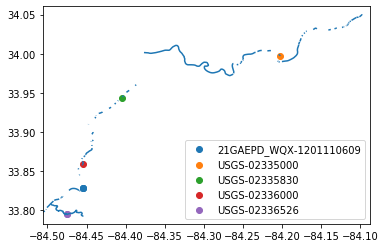

In [14]:
#plot stations

fig, ax = plt.subplots()
ax.set_xlim(pc_bbox[0]-.01, cr_bbox[2]+.01)
ax.set_ylim(pc_bbox[1]-.01, cr_bbox[3]+.01)

proctor_creek.plot(ax=ax)
chattahoochee_river.plot(ax=ax)

for i in np.unique(good_sites):
    pc_stations[pc_stations['MonitoringLocationIdentifier']==i].plot(ax=ax,label=i)
    cr_stations[cr_stations['MonitoringLocationIdentifier']==i].plot(ax=ax,label=i)
    
ax.legend(loc=4)

In [15]:
### John Pederson, F19 ###

#importing dependencies
from sklearn.preprocessing import StandardScaler

dates = cc_f['ActivityStartDate'].values.tolist()
datetimes = pd.to_datetime(dates)
cc_f = cc_f
cc_f ['DateTimes'] = datetimes

dates = sc_f['ActivityStartDate'].values.tolist()
datetimes = pd.to_datetime(dates)
sc_f = sc_f
sc_f ['DateTimes'] = datetimes

dates = tu_f['ActivityStartDate'].values.tolist()
datetimes = pd.to_datetime(dates)
tu_f = tu_f
tu_f ['DateTimes'] = datetimes

samples = pd.DataFrame()
for i in range(len(cc_f)):
    if not np.isnan(cc_f['ResultMeasureValue'].tolist()[i]):
        vec = [cc_f['ResultMeasureValue'].tolist()[i]]
        loc = cc_f['MonitoringLocationIdentifier'].tolist()[i]
        dat = cc_f['DateTimes'].tolist()[i]
        
        sc_i = sc_f[sc_f['DateTimes']==dat]
        sc_i = sc_i[sc_i['MonitoringLocationIdentifier']==loc]
        if len(sc_i) == 1:
            vec.append(sc_i['ResultMeasureValue'].tolist()[0])
        
        tu_i = tu_f[tu_f['DateTimes']==dat]
        tu_i = tu_i[tu_i['MonitoringLocationIdentifier']==loc]
        if len(tu_i) == 1:
            vec.append(tu_i['ResultMeasureValue'].tolist()[0])
        
        if len(vec) == 3:
            col = vec[0]
            con = vec[1]
            tur = vec[2]
            samp_i = pd.DataFrame({'Loc':[loc],'Date':[dat],'Col':[col],'Con':[con],'Tur':[tur]})
            samples = pd.concat((samples,samp_i),axis=0)

print(samples.head(5))
samples.to_csv('data/sample_dataframe_totalcoliform.csv')

             Loc       Date      Col   Con  Tur
0  USGS-02335000 2001-08-21  12000.0  49.0  7.4
0  USGS-02335000 2001-08-22    720.0  50.0  3.7
0  USGS-02335000 2001-08-23   1200.0  52.0  4.0
0  USGS-02335000 2001-08-28   1600.0  52.0  2.8
0  USGS-02335000 2001-08-29    880.0  53.0  2.5


In [16]:
### John Pederson, F19 ###

#loading dependencies
import plotly.graph_objects as go
import plotly

scale = StandardScaler()

labels = np.array(samples['Loc'].tolist())
col = scale.fit_transform(samples['Col'].values.reshape(-1,1))
con = scale.fit_transform(samples['Con'].values.reshape(-1,1))
tur = scale.fit_transform(samples['Tur'].values.reshape(-1,1))

col = [i[0] for i in col]
con = [i[0] for i in con]
tur = [i[0] for i in tur]

samples['Col_Std'] = col
samples['Con_Std'] = con
samples['Tur_Std'] = tur

fig = go.Figure()
fig_2 = go.Figure()
fig.update_layout(scene = dict(xaxis_title='Std Coliform',yaxis_title='Std Conductance',zaxis_title='Std Turbidity'))
for i in range(len(good_sites)):
    samp_i = samples[samples['Loc']==good_sites[i]]
    fig.add_trace(go.Scatter3d(x=samp_i['Col_Std'].tolist(),y=samp_i['Con_Std'].tolist(),z=samp_i['Tur_Std'].tolist(),name=good_sites[i],mode='markers',marker=dict(size=3,color=i)))
    fig_2.add_trace(go.Scatter(x=samp_i['Date'].tolist(),y=samp_i['Col_Std'].tolist()))

plotly.offline.plot(fig, filename='totalcoliform.html')
plotly.offline.plot(fig_2, filename='totalcoliform_2.html')

'totalcoliform_2.html'